# Quantified Self  
_Author : Carolyn Bozin_  
_Date Updated : 21/21/2022_  
_Course : CPSC222_  
## 1. Introduction  
In this Jupyter Notebook I will be exploring some of my own data through a multipstep process. The domain where my data is gathered from is Google Maps. Specifically. I am using my "Semantic Location" Data from the Google Takeout service. I am interested in doing research on this data because I want to see if I have different movement habits (i.e. deviation in distance travelled, amount of time taken, and activity type) during different portions of my life. Last Spring I studied abroad in Madrid, Spain, and I am especially curious to see if my movement patterns were different there than they are in Spokane.  

### About my Data

The dataset is in multiple JSON files which are seperated by month. The tables that I am including from the dataset are all from the "Activity Segment" portion of the JSON file, which is just periods when I moved from one location to another. The attributes of my Activity Segments that I am including are as listed in this chart:

1. **Start Timestamp** : Date and time when I started the activity segment (time zone accounted for)
1. **End Timestamp** : date and time when I ended the activity segment (time zone accounted for)
1. **Start Latitude** : Latitude (formatted with no decimal point) of starting location
1. **Start Longitude** : Longitude (formatted with no decimal point) of starting location
1. **End Latitude** : Latitude (formatted with no decimal point) of ending location
1. **End Longitude** : Longitude (formatted with no decimal point) of ending location
1. **Distance** : distance travelled in meters
1. **Activity** : my method of travel. Activities that are represented in my data are walking, riding the subway, riding the bus, riding in a passenger vehicle (car), riding on a plane, riding a ferry, and riding a train

>Note: This data was all collected by Google Maps through either cell service or GPS. 
  
The data that I decided to pull from the dataset are from the time that I was studying abroad, which is roughly from Jan 21 2022 to May 5 2022, and additionally from last Summer when I was in Spokane, whcih is roughly from May 22 2022 to August 14 2022. This turns out to be about 642 instances for my study abroad data and about 363 instances for my Spokane data. 

### Hypotheses  
One of my hypotheses are that the activity types for the two samples will be vastly different, because I walked a lot more in Spain than I normally do. I also rode the subway and train, and we do not even have a subway in Spokane. I pretty much already know that the activity type for Spokane will be mostly "passenger vehicle." Another hypothesis I have is that my average distance travelled in Spain was larger than in Spokane, but not by a lot. My reasoning is that although I did not have a car to travel large distances, I travelled by train and plane there occasionally. 

My next few hypotheses are only regarding the Spain sample. One hypothesis I have is that the mean distance travelled per day increased from the first half of my study abroad experience to the second half, because I got more comfortable and was probably travelling more. I also have hypotheses about my travel patterns in Spain on weekdays vs weekends. Specifically, I think that mean distance travelled over weekends will be larger than on weekdays, since I had more free time and did not have school. As a side note, I am including Fridays in my weekends because I did not have classes.  I am going to use the kNN algroithm and a Decision Tree to classify data on "weekend" vs "weekday" labels. 

Finally, I am going to use the MeteoStat weather API to test my hypothesis that I did not travel significantly less distance when the temperature was lower. My reasoning is that I had to go to school most days no matter the weather, and also I tried to get the most out of my time there even if it was cold. It also did not get super cold except for when I first arrived there.

### Potential Impacts & Stakeholders  
Mostly these results are to sate my own curiosity. However, a potential impact could be an imporved self awareness of my travel methods. In particular, maybe seeing how much I walked in Spain will motivate me to walk more back in Spokane. Potential stakeholders in this project is really just me and possibly students wanting to study abroad and Spain who want to know the most common modes of transport there.


## 2. Exploratory Data Analysis (EDA)   
Now that I have explained the data a little bit, we can continue to the EDA. This section will consist of loading the data, cleaning the data, making vizualizations, and finallly doing hypothesis tests.
### I. Data Loading  
#### a. Making a Dataframe
The first step is to load the data from JSON format into one big dataframe that contains all the dates I need. Overall I need data from January, February, March, April, May, June, July, and August of 2022. I will split the data up later.

>Note : I used [`pd.concat()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) to combine the different months. 

In [155]:
import pandas as pd
import utils 
import importlib
importlib.reload(utils) # to reload utils every time

jan_aug_df = utils.load_data()
jan_aug_df

,timelineObjects
0,{'placeVisit': {'location': {'latitudeE7': 477...
1,{'activitySegment': {'startLocation': {'latitu...
2,{'placeVisit': {'location': {'latitudeE7': 477...
3,{'activitySegment': {'startLocation': {'latitu...
4,{'placeVisit': {'location': {'latitudeE7': 478...
...,...
242,{'activitySegment': {'startLocation': {'latitu...
243,{'placeVisit': {'location': {'latitudeE7': 476...
244,{'placeVisit': {'location': {'latitudeE7': 476...
245,{'activitySegment': {'startLocation': {'latitu...


The data from the months I need is now in a dataframe title "timeline Objects". Granted, it still contains information I do not want (such as place visit data) and it is not organized into two dataframes like I want it to be. The next step is to take care of both these things.

#### b. Split Into Two Dataframes  
In this section, I will split the Google Maps dataframe of JSON data into two dataframes (one for Madrid, one for Spokane) based on the Start Timestamps of each activity segment. I will also convert the Timestamps to Python Datetime objects, which will make them slightly more human readable and a lot easier to work with. 


In order to properly split the data into two dataframes, I need to know the datatypes that I will be working with. To do this I can simply print the `type()` of one of the instances in my "timeline Objects" dataframe.

In [156]:
print(type(jan_aug_df["timelineObjects"].iloc[0]))

<class 'dict'>


It looks like the data is in dictionary format, which is unsurprising because it comes in JSON format. The next step will be to parse through the dataframe, go into each activity segment while ignoring the place visits, and grab all of the data for each activity segment that has a Start Timestamp within the range of dates I want. To get the index of the data I need, I will print out activity segments from the first and last day of my range. I will then pick the first and last indeces printed as my indeces to split the dataframe on.

For my study abroad data, I will pass in the dates 2022-01-21 and 2022-05-05 to my utility functino, which will print the indeces I want.

In [157]:
utils.get_start_end(jan_aug_df, "2022-01-21", "2022-05-05")

118
120
122
124
126
128
130
132
134
136
137
1316
1318
1320
1321
1322
1324
1326
1328
1329
1331
1333


The first instance from the start date is 118, and the last instance from the end date is 1333. Using these two values to divide the dataframe I can parse through the JSON data in jan_to_aug.csv and make a new dataframe of the data from my time in Madrid.

In [158]:
start = 118
end = 1333

study_abroad_df = utils.make_dataframe(jan_aug_df, start, end)
study_abroad_df

,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity
0,2022-01-21T09:13:23Z,2022-01-21T09:20:45.491Z,404072887,-37037391,404118401,-37052917,634,WALKING
1,2022-01-21T10:58:40.449Z,2022-01-21T11:23:11.776Z,404124269,-37045765,404083941,-36930145,1289,WALKING
2,2022-01-21T11:31:20.770Z,2022-01-21T12:22:11.361Z,404095404,-36928230,404181546,-37046289,2670,WALKING
3,2022-01-21T12:29:27.539Z,2022-01-21T12:40:28.366Z,404167013,-37044784,404185364,-37098021,607,WALKING
4,2022-01-21T14:40:28.840Z,2022-01-21T14:48:36.275Z,404163340,-37087356,404161470,-37032274,499,WALKING
...,...,...,...,...,...,...,...,...
637,2022-05-05T14:32:53.709Z,2022-05-05T14:34:57.181Z,404182319,-37095123,404202932,-37059859,376,IN_SUBWAY
638,2022-05-05T14:40:04.529Z,2022-05-05T14:51:58.837Z,404203902,-37063509,404069457,-37037075,2149,IN_SUBWAY
639,2022-05-05T17:24:51.042Z,2022-05-05T17:38:07.070Z,404066533,-37035654,404047651,-37023939,610,WALKING
640,2022-05-05T17:38:07.070Z,2022-05-05T17:52:17.360Z,404047651,-37023939,404262112,-37011621,2438,IN_SUBWAY


This looks much cleaner than the JSON data! Now that we have a dataframe for my study abroad time, the next step is to make one for my time in Spokane last Summer. This will include all instances from the dates 2022-05-22 to 2022-08-22.

In [159]:
utils.get_start_end(jan_aug_df, "2022-05-22", "2022-08-14")

1491
1493
2210
2212
2214
2216


The first instance from the start date is 1491, and the last index from the end date is 2216. Now we can make a dataframe for my data from Spokane in the Summer of 2022. 

In [160]:
start = 1491
end = 2216

summer_df = utils.make_dataframe(jan_aug_df, start, end)
summer_df

,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity
0,2022-05-22T00:26:53.487Z,2022-05-22T01:04:16.530Z,477019914,-1174127539,478158715,-1173468857,16009,IN_PASSENGER_VEHICLE
1,2022-05-22T21:48:14Z,2022-05-22T22:05:39Z,478566574,-1172777957,477719874,-1174023325,19129,IN_PASSENGER_VEHICLE
2,2022-05-23T00:27:20Z,2022-05-23T00:47:08.449Z,477731568,-1174029817,478561191,-1172749742,17875,IN_PASSENGER_VEHICLE
3,2022-05-23T16:16:00.836Z,2022-05-23T16:58:48.051Z,478561216,-1172749754,476676638,-1174008391,28584,IN_PASSENGER_VEHICLE
4,2022-05-23T23:08:05.143Z,2022-05-23T23:44:36.050Z,476684577,-1174024072,478407460,-1173540569,20647,IN_PASSENGER_VEHICLE
...,...,...,...,...,...,...,...,...
358,2022-08-13T01:38:03.467Z,2022-08-13T02:52:07.291Z,476747573,-1173909960,478560977,-1172754508,26251,IN_PASSENGER_VEHICLE
359,2022-08-13T03:20:43.385Z,2022-08-13T04:13:20.389Z,478562593,-1172756483,476747751,-1173905676,22070,IN_PASSENGER_VEHICLE
360,2022-08-14T01:08:02.334Z,2022-08-14T01:24:07Z,476748260,-1173907931,476438752,-1174103693,5487,IN_PASSENGER_VEHICLE
361,2022-08-14T03:29:46Z,2022-08-14T03:41:20Z,476451787,-1174110853,476748346,-1173911600,4849,IN_PASSENGER_VEHICLE


### II. Data Cleaning 
#### a. Check For Missing Values  
I did not see any missing data while parsing through the dataframes visually, but just in case I will check with Python using the `df.isna()` function along with `.value_counts()`.

In [161]:
print(study_abroad_df.isna().value_counts())
print(summer_df.isna().value_counts())

Start Timestamp  End Timestamp  Start Latitude  Start Longitude  End Latitude  End Longitude  Distance (m)  Activity
False            False          False           False            False         False          False         False       642
dtype: int64
Start Timestamp  End Timestamp  Start Latitude  Start Longitude  End Latitude  End Longitude  Distance (m)  Activity
False            False          False           False            False         False          False         False       363
dtype: int64


Just as I suspected, all the columns are 'False' meaning there are no missing values.

#### b. Convert Timestamps to DateTime 
 The next step is to take the Start and End Timestamps and convert them to pandas `dateTime` objects so that they are easier to work with later on.

In [162]:
start_fixed = pd.to_datetime(summer_df["Start Timestamp"])
end_fixed = pd.to_datetime(summer_df["End Timestamp"])

summer_df["Start Timestamp"] = start_fixed
summer_df["End Timestamp"] = end_fixed

summer_df

,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity
0,2022-05-22 00:26:53.487000+00:00,2022-05-22 01:04:16.530000+00:00,477019914,-1174127539,478158715,-1173468857,16009,IN_PASSENGER_VEHICLE
1,2022-05-22 21:48:14+00:00,2022-05-22 22:05:39+00:00,478566574,-1172777957,477719874,-1174023325,19129,IN_PASSENGER_VEHICLE
2,2022-05-23 00:27:20+00:00,2022-05-23 00:47:08.449000+00:00,477731568,-1174029817,478561191,-1172749742,17875,IN_PASSENGER_VEHICLE
3,2022-05-23 16:16:00.836000+00:00,2022-05-23 16:58:48.051000+00:00,478561216,-1172749754,476676638,-1174008391,28584,IN_PASSENGER_VEHICLE
4,2022-05-23 23:08:05.143000+00:00,2022-05-23 23:44:36.050000+00:00,476684577,-1174024072,478407460,-1173540569,20647,IN_PASSENGER_VEHICLE
...,...,...,...,...,...,...,...,...
358,2022-08-13 01:38:03.467000+00:00,2022-08-13 02:52:07.291000+00:00,476747573,-1173909960,478560977,-1172754508,26251,IN_PASSENGER_VEHICLE
359,2022-08-13 03:20:43.385000+00:00,2022-08-13 04:13:20.389000+00:00,478562593,-1172756483,476747751,-1173905676,22070,IN_PASSENGER_VEHICLE
360,2022-08-14 01:08:02.334000+00:00,2022-08-14 01:24:07+00:00,476748260,-1173907931,476438752,-1174103693,5487,IN_PASSENGER_VEHICLE
361,2022-08-14 03:29:46+00:00,2022-08-14 03:41:20+00:00,476451787,-1174110853,476748346,-1173911600,4849,IN_PASSENGER_VEHICLE


That still looks a bit cluttered, but at the very least it is in a better format and timezones have been adjusted for. Next we have to do the same for the study abroad data.

In [163]:
start_fixed = pd.to_datetime(study_abroad_df["Start Timestamp"])
end_fixed = pd.to_datetime(study_abroad_df["End Timestamp"])

study_abroad_df["Start Timestamp"] = start_fixed
study_abroad_df["End Timestamp"] = end_fixed

study_abroad_df

,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity
0,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,404072887,-37037391,404118401,-37052917,634,WALKING
1,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,404124269,-37045765,404083941,-36930145,1289,WALKING
2,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,404095404,-36928230,404181546,-37046289,2670,WALKING
3,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,404167013,-37044784,404185364,-37098021,607,WALKING
4,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,404163340,-37087356,404161470,-37032274,499,WALKING
...,...,...,...,...,...,...,...,...
637,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,404182319,-37095123,404202932,-37059859,376,IN_SUBWAY
638,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,404203902,-37063509,404069457,-37037075,2149,IN_SUBWAY
639,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,404066533,-37035654,404047651,-37023939,610,WALKING
640,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,404047651,-37023939,404262112,-37011621,2438,IN_SUBWAY


#### c. Add Date Column  
Since I am going to do some analysis on daily activity later on, it will be useful to add a seperate column with just the dates extracted from the timestamps. We can do this by using [strftime()](https://www.programiz.com/python-programming/datetime/strftime) (a function to convert datetime objects to strings) in a utility function.

In [164]:
date_lst = utils.make_date_col(study_abroad_df)
# add col to study abroad df
study_abroad_df.insert(column="Date", value=date_lst, loc=0)
study_abroad_df

,Date,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity
0,2022-01-21,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,404072887,-37037391,404118401,-37052917,634,WALKING
1,2022-01-21,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,404124269,-37045765,404083941,-36930145,1289,WALKING
2,2022-01-21,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,404095404,-36928230,404181546,-37046289,2670,WALKING
3,2022-01-21,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,404167013,-37044784,404185364,-37098021,607,WALKING
4,2022-01-21,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,404163340,-37087356,404161470,-37032274,499,WALKING
...,...,...,...,...,...,...,...,...,...
637,2022-05-05,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,404182319,-37095123,404202932,-37059859,376,IN_SUBWAY
638,2022-05-05,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,404203902,-37063509,404069457,-37037075,2149,IN_SUBWAY
639,2022-05-05,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,404066533,-37035654,404047651,-37023939,610,WALKING
640,2022-05-05,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,404047651,-37023939,404262112,-37011621,2438,IN_SUBWAY


In [165]:

date_lst = utils.make_date_col(summer_df)
# add col to summer df
summer_df.insert(column="Date", value=date_lst, loc=0)
summer_df

,Date,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity
0,2022-05-22,2022-05-22 00:26:53.487000+00:00,2022-05-22 01:04:16.530000+00:00,477019914,-1174127539,478158715,-1173468857,16009,IN_PASSENGER_VEHICLE
1,2022-05-22,2022-05-22 21:48:14+00:00,2022-05-22 22:05:39+00:00,478566574,-1172777957,477719874,-1174023325,19129,IN_PASSENGER_VEHICLE
2,2022-05-23,2022-05-23 00:27:20+00:00,2022-05-23 00:47:08.449000+00:00,477731568,-1174029817,478561191,-1172749742,17875,IN_PASSENGER_VEHICLE
3,2022-05-23,2022-05-23 16:16:00.836000+00:00,2022-05-23 16:58:48.051000+00:00,478561216,-1172749754,476676638,-1174008391,28584,IN_PASSENGER_VEHICLE
4,2022-05-23,2022-05-23 23:08:05.143000+00:00,2022-05-23 23:44:36.050000+00:00,476684577,-1174024072,478407460,-1173540569,20647,IN_PASSENGER_VEHICLE
...,...,...,...,...,...,...,...,...,...
358,2022-08-13,2022-08-13 01:38:03.467000+00:00,2022-08-13 02:52:07.291000+00:00,476747573,-1173909960,478560977,-1172754508,26251,IN_PASSENGER_VEHICLE
359,2022-08-13,2022-08-13 03:20:43.385000+00:00,2022-08-13 04:13:20.389000+00:00,478562593,-1172756483,476747751,-1173905676,22070,IN_PASSENGER_VEHICLE
360,2022-08-14,2022-08-14 01:08:02.334000+00:00,2022-08-14 01:24:07+00:00,476748260,-1173907931,476438752,-1174103693,5487,IN_PASSENGER_VEHICLE
361,2022-08-14,2022-08-14 03:29:46+00:00,2022-08-14 03:41:20+00:00,476451787,-1174110853,476748346,-1173911600,4849,IN_PASSENGER_VEHICLE


The date column looks good. Now we can move on to the Latitude and Longitude.

#### d. Fix Latitude and Longitude Columns   
The latitude and longitude is not displayed badly, but adding a decimal point would make it more understandable to the viewer. Using my knowledge of the latitude and longitude of both Madrid and Spain, I will insert a decimal point into each of these values.

In [166]:
#madrid
utils.fix_lat_lon_all(study_abroad_df)
study_abroad_df

,Date,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity
0,2022-01-21,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,40.4072887,-3.7037391,40.4118401,-3.7052917,634,WALKING
1,2022-01-21,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,40.4124269,-3.7045765,40.4083941,-3.6930145,1289,WALKING
2,2022-01-21,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,40.4095404,-3.6928230,40.4181546,-3.7046289,2670,WALKING
3,2022-01-21,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,40.4167013,-3.7044784,40.4185364,-3.7098021,607,WALKING
4,2022-01-21,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,40.4163340,-3.7087356,40.4161470,-3.7032274,499,WALKING
...,...,...,...,...,...,...,...,...,...
637,2022-05-05,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,40.4182319,-3.7095123,40.4202932,-3.7059859,376,IN_SUBWAY
638,2022-05-05,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,40.4203902,-3.7063509,40.4069457,-3.7037075,2149,IN_SUBWAY
639,2022-05-05,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,40.4066533,-3.7035654,40.4047651,-3.7023939,610,WALKING
640,2022-05-05,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,40.4047651,-3.7023939,40.4262112,-3.7011621,2438,IN_SUBWAY


In [167]:
#spokane
utils.fix_lat_lon_all(summer_df)
summer_df

,Date,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity
0,2022-05-22,2022-05-22 00:26:53.487000+00:00,2022-05-22 01:04:16.530000+00:00,47.7019914,-1.174127539,47.8158715,-1.173468857,16009,IN_PASSENGER_VEHICLE
1,2022-05-22,2022-05-22 21:48:14+00:00,2022-05-22 22:05:39+00:00,47.8566574,-1.172777957,47.7719874,-1.174023325,19129,IN_PASSENGER_VEHICLE
2,2022-05-23,2022-05-23 00:27:20+00:00,2022-05-23 00:47:08.449000+00:00,47.7731568,-1.174029817,47.8561191,-1.172749742,17875,IN_PASSENGER_VEHICLE
3,2022-05-23,2022-05-23 16:16:00.836000+00:00,2022-05-23 16:58:48.051000+00:00,47.8561216,-1.172749754,47.6676638,-1.174008391,28584,IN_PASSENGER_VEHICLE
4,2022-05-23,2022-05-23 23:08:05.143000+00:00,2022-05-23 23:44:36.050000+00:00,47.6684577,-1.174024072,47.8407460,-1.173540569,20647,IN_PASSENGER_VEHICLE
...,...,...,...,...,...,...,...,...,...
358,2022-08-13,2022-08-13 01:38:03.467000+00:00,2022-08-13 02:52:07.291000+00:00,47.6747573,-1.173909960,47.8560977,-1.172754508,26251,IN_PASSENGER_VEHICLE
359,2022-08-13,2022-08-13 03:20:43.385000+00:00,2022-08-13 04:13:20.389000+00:00,47.8562593,-1.172756483,47.6747751,-1.173905676,22070,IN_PASSENGER_VEHICLE
360,2022-08-14,2022-08-14 01:08:02.334000+00:00,2022-08-14 01:24:07+00:00,47.6748260,-1.173907931,47.6438752,-1.174103693,5487,IN_PASSENGER_VEHICLE
361,2022-08-14,2022-08-14 03:29:46+00:00,2022-08-14 03:41:20+00:00,47.6451787,-1.174110853,47.6748346,-1.173911600,4849,IN_PASSENGER_VEHICLE


#### e. Make Activity Column Numeric  
The last step in cleaning this data will be to encode the Activity column into numeric data using the `sklearn.preprocessing.LabelEncoder()`. This will help down the road when I will be doing hypothesis testing on my Activity data. I will still keep the original categorical Activity data just so it is more user friendly. So that the encoding is consistent across both dataframes, I will first concatenate them and make one large dataframe. Then after wncoding I will seperate them once again.

In [168]:
combined_df = pd.concat([study_abroad_df, summer_df])

num_act = utils.encode_column(combined_df, "Activity")
# replace old col in combined df
combined_df["Activity"] = num_act
combined_df

,Date,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity
0,2022-01-21,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,40.4072887,-3.7037391,40.4118401,-3.7052917,634,7
1,2022-01-21,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,40.4124269,-3.7045765,40.4083941,-3.6930145,1289,7
2,2022-01-21,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,40.4095404,-3.6928230,40.4181546,-3.7046289,2670,7
3,2022-01-21,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,40.4167013,-3.7044784,40.4185364,-3.7098021,607,7
4,2022-01-21,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,40.4163340,-3.7087356,40.4161470,-3.7032274,499,7
...,...,...,...,...,...,...,...,...,...
358,2022-08-13,2022-08-13 01:38:03.467000+00:00,2022-08-13 02:52:07.291000+00:00,47.6747573,-1.173909960,47.8560977,-1.172754508,26251,3
359,2022-08-13,2022-08-13 03:20:43.385000+00:00,2022-08-13 04:13:20.389000+00:00,47.8562593,-1.172756483,47.6747751,-1.173905676,22070,3
360,2022-08-14,2022-08-14 01:08:02.334000+00:00,2022-08-14 01:24:07+00:00,47.6748260,-1.173907931,47.6438752,-1.174103693,5487,3
361,2022-08-14,2022-08-14 03:29:46+00:00,2022-08-14 03:41:20+00:00,47.6451787,-1.174110853,47.6748346,-1.173911600,4849,3


Looks like the Activity column was encoded properly! Here is a key to the encoded data:
> Flying = 0, In Bus = 1, In Ferry = 2, In Passenger Vehicle = 3, In Subway = 4, In Train = 5, Unknown = 6, Walking = 7  

Now we can split this dataframe in two once again.

In [169]:
study_abroad_lst, summer_lst = utils.split_col(combined_df, "Activity", 642)

#insert cols into both dfs 
study_abroad_df.insert(loc=9, value=study_abroad_lst, column="Activity Code")
summer_df.insert(loc=9, value=summer_lst, column="Activity Code")

In [170]:
summer_df

,Date,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity,Activity Code
0,2022-05-22,2022-05-22 00:26:53.487000+00:00,2022-05-22 01:04:16.530000+00:00,47.7019914,-1.174127539,47.8158715,-1.173468857,16009,IN_PASSENGER_VEHICLE,3
1,2022-05-22,2022-05-22 21:48:14+00:00,2022-05-22 22:05:39+00:00,47.8566574,-1.172777957,47.7719874,-1.174023325,19129,IN_PASSENGER_VEHICLE,3
2,2022-05-23,2022-05-23 00:27:20+00:00,2022-05-23 00:47:08.449000+00:00,47.7731568,-1.174029817,47.8561191,-1.172749742,17875,IN_PASSENGER_VEHICLE,3
3,2022-05-23,2022-05-23 16:16:00.836000+00:00,2022-05-23 16:58:48.051000+00:00,47.8561216,-1.172749754,47.6676638,-1.174008391,28584,IN_PASSENGER_VEHICLE,3
4,2022-05-23,2022-05-23 23:08:05.143000+00:00,2022-05-23 23:44:36.050000+00:00,47.6684577,-1.174024072,47.8407460,-1.173540569,20647,IN_PASSENGER_VEHICLE,3
...,...,...,...,...,...,...,...,...,...,...
358,2022-08-13,2022-08-13 01:38:03.467000+00:00,2022-08-13 02:52:07.291000+00:00,47.6747573,-1.173909960,47.8560977,-1.172754508,26251,IN_PASSENGER_VEHICLE,3
359,2022-08-13,2022-08-13 03:20:43.385000+00:00,2022-08-13 04:13:20.389000+00:00,47.8562593,-1.172756483,47.6747751,-1.173905676,22070,IN_PASSENGER_VEHICLE,3
360,2022-08-14,2022-08-14 01:08:02.334000+00:00,2022-08-14 01:24:07+00:00,47.6748260,-1.173907931,47.6438752,-1.174103693,5487,IN_PASSENGER_VEHICLE,3
361,2022-08-14,2022-08-14 03:29:46+00:00,2022-08-14 03:41:20+00:00,47.6451787,-1.174110853,47.6748346,-1.173911600,4849,IN_PASSENGER_VEHICLE,3


The activity code column has been properly inserted.

In [171]:
days = pd.read_csv("days_week.csv")
study_abroad_df.insert(value=days["Day"], column="Day of Week", loc=1)
study_abroad_df

,Date,Day of Week,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity,Activity Code
0,2022-01-21,Friday,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,40.4072887,-3.7037391,40.4118401,-3.7052917,634,WALKING,7
1,2022-01-21,Friday,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,40.4124269,-3.7045765,40.4083941,-3.6930145,1289,WALKING,7
2,2022-01-21,Friday,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,40.4095404,-3.6928230,40.4181546,-3.7046289,2670,WALKING,7
3,2022-01-21,Friday,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,40.4167013,-3.7044784,40.4185364,-3.7098021,607,WALKING,7
4,2022-01-21,Friday,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,40.4163340,-3.7087356,40.4161470,-3.7032274,499,WALKING,7
...,...,...,...,...,...,...,...,...,...,...,...
637,2022-05-05,Thursday,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,40.4182319,-3.7095123,40.4202932,-3.7059859,376,IN_SUBWAY,4
638,2022-05-05,Thursday,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,40.4203902,-3.7063509,40.4069457,-3.7037075,2149,IN_SUBWAY,4
639,2022-05-05,Thursday,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,40.4066533,-3.7035654,40.4047651,-3.7023939,610,WALKING,7
640,2022-05-05,Thursday,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,40.4047651,-3.7023939,40.4262112,-3.7011621,2438,IN_SUBWAY,4


### III. Join on Daily Weather Data
Now that the dataset has been cleaned, I can continue to the next step, which is joining my study abroad dataframe with weather data using the Meteostat API. I am only joining with the study abroad data in this case because my hypotheses involving weather only apply to this dataset and not the one from Spokane. 

This step was a bit of a pain for me. At first I tried to use each instance in the the "Start Latitude" and "Start Longitude" columns to generate a list of weather station IDs that were gathered using the Find Station functionality of the Meteostat API. This gave me a lot of trouble because I realized that the Lat/Long columns were not formatted correctly (they did mnot have decimals). Because of this I went back to the cleaning stage and inserted a section where I added decimal points to all of the Lat/Long data. This ended up generating results, but there were still some Lat/Long values that did not generate a station ID and this was breaking my code. Evenually I figured out how to get np.NaN values inserted in these cases. Finally, the code was not crashing, and I got it to run ok.

However, the code was taking a _lot_ of time to run, and also used up all of the requests available to me at for free. Thus, I had to rethink how I was going to do this. Instead of getting a seperate station ID for every instance of my dataframe, I googled the latitude and longitude of Madrid and used the MeteoSTat API user interface (limiting the number of stations to 1) to get one station for all of my data. This is not the most accurate way to represent weather data during my time abroad, because I did not spend all of my time in Madrid. However, it was better than getting individual stations for all of my instances. After getting the ID of the weather station, I used several utility functions in a python file called `weather_data.py` in order to request daily weather data from the API. I then sent the daily weather data to a csv file called `daily_weather_madrid.csv`. This is convenient because it keeps my API key outside of this project and also makes it so that every time I run this file I don't have to request the same data again. 

Grabbing the data will be easy, I can just read from a csv file into a new dataframe.

In [172]:
weather_df = pd.read_csv("daily_weather_madrid.csv")
weather_df

,Unnamed: 0,Date,Avg Temp,Min Temp,Max Temp,Precip.,Snow,Wind Dir.,Wind Speed,Peak Wind Gust,Pressure,Total Sun
0,0,2022-01-21,40.8,33.8,48.0,0.000,NaN,32.0,6.6,NaN,1027.9,NaN
1,1,2022-01-22,41.0,34.2,48.7,0.000,NaN,37.0,6.5,NaN,1030.8,NaN
2,2,2022-01-23,42.4,36.3,48.7,0.000,NaN,49.0,5.3,NaN,1028.1,NaN
3,3,2022-01-24,43.9,39.2,47.3,0.000,NaN,40.0,4.9,NaN,1028.8,NaN
4,4,2022-01-25,46.2,39.7,50.7,0.000,NaN,62.0,5.5,NaN,1031.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
100,100,2022-05-01,62.4,55.2,77.9,0.000,NaN,321.0,4.7,NaN,1017.8,NaN
101,101,2022-05-02,57.6,53.6,66.9,0.087,NaN,8.0,6.5,NaN,1011.2,NaN
102,102,2022-05-03,55.9,52.0,63.5,0.102,NaN,50.0,10.8,NaN,1011.8,NaN
103,103,2022-05-04,57.7,50.4,68.4,0.000,NaN,42.0,9.8,NaN,1016.1,NaN


Now that I have succesfully gotten the data into a dataframe, it would be good to drop the columns that are full of missing values (Snow, Peak Wind Gust, and Total Sun). I will use a threshold of 50, meaning that columns with over 50 missing instances will be dropped. I will also drop the "Unnamed :0" column as it seems to just be an nidex column.

In [173]:
weather_df.dropna(axis=1, inplace=True, thresh=50)
weather_df.drop("Unnamed: 0", axis=1, inplace=True)
weather_df

,Date,Avg Temp,Min Temp,Max Temp,Precip.,Wind Dir.,Wind Speed,Pressure
0,2022-01-21,40.8,33.8,48.0,0.000,32.0,6.6,1027.9
1,2022-01-22,41.0,34.2,48.7,0.000,37.0,6.5,1030.8
2,2022-01-23,42.4,36.3,48.7,0.000,49.0,5.3,1028.1
3,2022-01-24,43.9,39.2,47.3,0.000,40.0,4.9,1028.8
4,2022-01-25,46.2,39.7,50.7,0.000,62.0,5.5,1031.7
...,...,...,...,...,...,...,...,...
100,2022-05-01,62.4,55.2,77.9,0.000,321.0,4.7,1017.8
101,2022-05-02,57.6,53.6,66.9,0.087,8.0,6.5,1011.2
102,2022-05-03,55.9,52.0,63.5,0.102,50.0,10.8,1011.8
103,2022-05-04,57.7,50.4,68.4,0.000,42.0,9.8,1016.1


That is looking a lot better. Now we can go ahead and do an inner join on this dataframe with the study abroad location dataframe. 

In [174]:
merged_df = study_abroad_df.merge(weather_df, how='inner', on="Date")
merged_df

,Date,Day of Week,Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity,Activity Code,Avg Temp,Min Temp,Max Temp,Precip.,Wind Dir.,Wind Speed,Pressure
0,2022-01-21,Friday,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,40.4072887,-3.7037391,40.4118401,-3.7052917,634,WALKING,7,40.8,33.8,48.0,0.0,32.0,6.6,1027.9
1,2022-01-21,Friday,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,40.4124269,-3.7045765,40.4083941,-3.6930145,1289,WALKING,7,40.8,33.8,48.0,0.0,32.0,6.6,1027.9
2,2022-01-21,Friday,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,40.4095404,-3.6928230,40.4181546,-3.7046289,2670,WALKING,7,40.8,33.8,48.0,0.0,32.0,6.6,1027.9
3,2022-01-21,Friday,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,40.4167013,-3.7044784,40.4185364,-3.7098021,607,WALKING,7,40.8,33.8,48.0,0.0,32.0,6.6,1027.9
4,2022-01-21,Friday,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,40.4163340,-3.7087356,40.4161470,-3.7032274,499,WALKING,7,40.8,33.8,48.0,0.0,32.0,6.6,1027.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2022-05-05,Thursday,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,40.4182319,-3.7095123,40.4202932,-3.7059859,376,IN_SUBWAY,4,58.8,51.1,74.1,0.0,27.0,5.4,1021.3
638,2022-05-05,Thursday,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,40.4203902,-3.7063509,40.4069457,-3.7037075,2149,IN_SUBWAY,4,58.8,51.1,74.1,0.0,27.0,5.4,1021.3
639,2022-05-05,Thursday,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,40.4066533,-3.7035654,40.4047651,-3.7023939,610,WALKING,7,58.8,51.1,74.1,0.0,27.0,5.4,1021.3
640,2022-05-05,Thursday,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,40.4047651,-3.7023939,40.4262112,-3.7011621,2438,IN_SUBWAY,4,58.8,51.1,74.1,0.0,27.0,5.4,1021.3


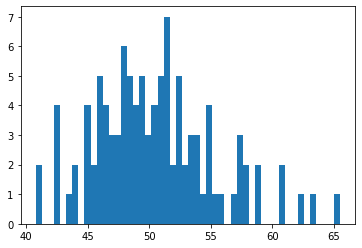

In [212]:
import matplotlib.pyplot as plt

plt.figure()
grouped_by_date = merged_df.groupby("Date")
avg_temp = grouped_by_date["Avg Temp"].mean()

plt.hist(avg_temp, bins=50)
plt.show()

### III. Aggregates & Data Visualizations  
The next step in our Exploratory Data Analysis is to perform various aggregate functions on the data, which will give hints as to if my hypotheses were correct or not.

#### a. Total Time per Activity Segment (Madrid vs Spokane)

In [175]:
dif_ser_min = utils.get_time_elapsed(study_abroad_df)

# add col to study abroad df
study_abroad_df.insert(column="Time Elapsed (min)", value=dif_ser_min, loc=2)
study_abroad_df

,Date,Day of Week,Time Elapsed (min),Start Timestamp,End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity,Activity Code
0,2022-01-21,Friday,7.374850,2022-01-21 09:13:23+00:00,2022-01-21 09:20:45.491000+00:00,40.4072887,-3.7037391,40.4118401,-3.7052917,634,WALKING,7
1,2022-01-21,Friday,24.522117,2022-01-21 10:58:40.449000+00:00,2022-01-21 11:23:11.776000+00:00,40.4124269,-3.7045765,40.4083941,-3.6930145,1289,WALKING,7
2,2022-01-21,Friday,50.843183,2022-01-21 11:31:20.770000+00:00,2022-01-21 12:22:11.361000+00:00,40.4095404,-3.6928230,40.4181546,-3.7046289,2670,WALKING,7
3,2022-01-21,Friday,11.013783,2022-01-21 12:29:27.539000+00:00,2022-01-21 12:40:28.366000+00:00,40.4167013,-3.7044784,40.4185364,-3.7098021,607,WALKING,7
4,2022-01-21,Friday,8.123917,2022-01-21 14:40:28.840000+00:00,2022-01-21 14:48:36.275000+00:00,40.4163340,-3.7087356,40.4161470,-3.7032274,499,WALKING,7
...,...,...,...,...,...,...,...,...,...,...,...,...
637,2022-05-05,Thursday,2.057867,2022-05-05 14:32:53.709000+00:00,2022-05-05 14:34:57.181000+00:00,40.4182319,-3.7095123,40.4202932,-3.7059859,376,IN_SUBWAY,4
638,2022-05-05,Thursday,11.905133,2022-05-05 14:40:04.529000+00:00,2022-05-05 14:51:58.837000+00:00,40.4203902,-3.7063509,40.4069457,-3.7037075,2149,IN_SUBWAY,4
639,2022-05-05,Thursday,13.267133,2022-05-05 17:24:51.042000+00:00,2022-05-05 17:38:07.070000+00:00,40.4066533,-3.7035654,40.4047651,-3.7023939,610,WALKING,7
640,2022-05-05,Thursday,14.171500,2022-05-05 17:38:07.070000+00:00,2022-05-05 17:52:17.360000+00:00,40.4047651,-3.7023939,40.4262112,-3.7011621,2438,IN_SUBWAY,4


In [176]:
dif_ser_min = utils.get_time_elapsed(summer_df)
# add col
summer_df.insert(column="Time Elapsed (min)", value=dif_ser_min, loc=2)
summer_df

,Date,Start Timestamp,Time Elapsed (min),End Timestamp,Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity,Activity Code
0,2022-05-22,2022-05-22 00:26:53.487000+00:00,37.384050,2022-05-22 01:04:16.530000+00:00,47.7019914,-1.174127539,47.8158715,-1.173468857,16009,IN_PASSENGER_VEHICLE,3
1,2022-05-22,2022-05-22 21:48:14+00:00,17.416667,2022-05-22 22:05:39+00:00,47.8566574,-1.172777957,47.7719874,-1.174023325,19129,IN_PASSENGER_VEHICLE,3
2,2022-05-23,2022-05-23 00:27:20+00:00,19.807483,2022-05-23 00:47:08.449000+00:00,47.7731568,-1.174029817,47.8561191,-1.172749742,17875,IN_PASSENGER_VEHICLE,3
3,2022-05-23,2022-05-23 16:16:00.836000+00:00,42.786917,2022-05-23 16:58:48.051000+00:00,47.8561216,-1.172749754,47.6676638,-1.174008391,28584,IN_PASSENGER_VEHICLE,3
4,2022-05-23,2022-05-23 23:08:05.143000+00:00,36.515117,2022-05-23 23:44:36.050000+00:00,47.6684577,-1.174024072,47.8407460,-1.173540569,20647,IN_PASSENGER_VEHICLE,3
...,...,...,...,...,...,...,...,...,...,...,...
358,2022-08-13,2022-08-13 01:38:03.467000+00:00,74.063733,2022-08-13 02:52:07.291000+00:00,47.6747573,-1.173909960,47.8560977,-1.172754508,26251,IN_PASSENGER_VEHICLE,3
359,2022-08-13,2022-08-13 03:20:43.385000+00:00,52.616733,2022-08-13 04:13:20.389000+00:00,47.8562593,-1.172756483,47.6747751,-1.173905676,22070,IN_PASSENGER_VEHICLE,3
360,2022-08-14,2022-08-14 01:08:02.334000+00:00,16.077767,2022-08-14 01:24:07+00:00,47.6748260,-1.173907931,47.6438752,-1.174103693,5487,IN_PASSENGER_VEHICLE,3
361,2022-08-14,2022-08-14 03:29:46+00:00,11.566667,2022-08-14 03:41:20+00:00,47.6451787,-1.174110853,47.6748346,-1.173911600,4849,IN_PASSENGER_VEHICLE,3


Now that the elapsed time per activity segment has been inserted, lets get a visualization of the data I used this [link](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html) to plot this.

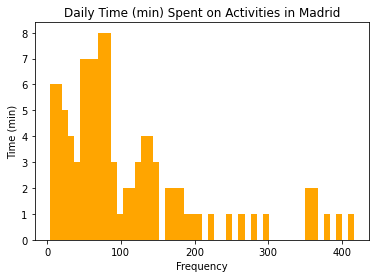

In [209]:
import matplotlib.pyplot as plt

grouped_by_date = study_abroad_df.groupby("Date")
time_per_day_madrid = grouped_by_date["Time Elapsed (min)"].sum()
plt.figure()

plt.title("Daily Time (min) Spent on Activities in Madrid")
plt.xlabel("Frequency")
plt.ylabel("Time (min)")

plt.hist( time_per_day_madrid, bins=50, color="orange")
plt.show()

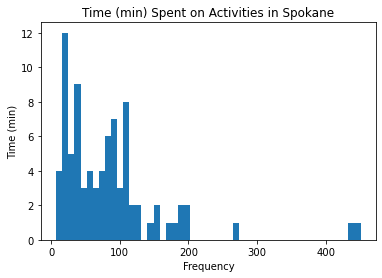

In [208]:
grouped_by_date = summer_df.groupby("Date")
time_per_day_spokane = grouped_by_date["Time Elapsed (min)"].sum()

plt.figure()

plt.title("Time (min) Spent on Activities in Spokane")
plt.xlabel("Frequency")
plt.ylabel("Time (min)")

plt.hist( time_per_day_spokane, bins=50)
plt.show()


The time data both seems to be distributed similarly (skewed right). 

#### b. Visualize Activity Frequency Spokane vs Madrid  
One of my hypotheses that I am almost certain about is that the "mean activity" (found using the codes generated by the label encoidder for each activity type) will be higher for Madrid, since I spent a lot of time walking (7) and on the Subway (4) and Train (5). In contrast most of my activitiues in Spokane involve my driving mu=y car (3).

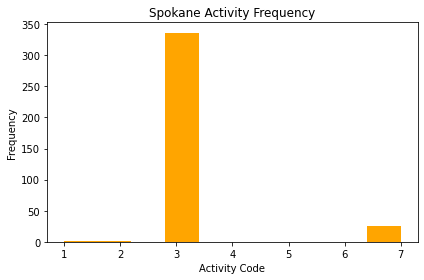

In [179]:
# labels
plt.title("Spokane Activity Frequency")
plt.xlabel("Activity Code")
plt.ylabel("Frequency")

# plot 
plt.hist(summer_df["Activity Code"], color="orange")
plt.tight_layout()
plt.show()

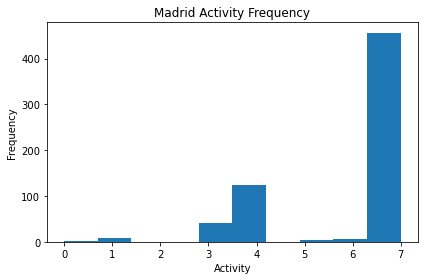

In [180]:
# new figure
plt.figure()

# labels
plt.title("Madrid Activity Frequency")
plt.xlabel("Activity")
plt.ylabel("Frequency")

# plot 
plt.hist(study_abroad_df["Activity Code"])

plt.tight_layout()
plt.show()

As expected, walking (7) amde up the majority of my activity segments in Madrid, with some passenger vehicle (3) and Subway (4). In spokane the majority of my activities were passenger vehicle (3).

#### c. Madrid Average Distance per Activity (km) First vs Second Half

In [181]:
first_half = study_abroad_df.iloc[0:322]
second_half = study_abroad_df[332:643]
print(first_half["Distance (m)"].mean())
print(second_half["Distance (m)"].mean())

6396.95652173913
11565.729032258065


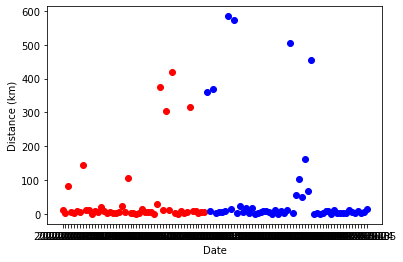

In [182]:
daily_total_distance_first= first_half.groupby("Date")["Distance (m)"].sum()
daily_total_distance_first /= 1000

daily_total_distance_last= second_half.groupby("Date")["Distance (m)"].sum()
daily_total_distance_last /= 1000

plt.figure()

#labels
plt.title("")
plt.xlabel("Date")
plt.ylabel("Distance (km)")

#plot
plt.scatter(daily_total_distance_first.index, daily_total_distance_first, color="red")
plt.scatter(daily_total_distance_last.index, daily_total_distance_last, color="blue")
plt.show()

#### d. Average Temp vs Daily Activity Time (Madrid)

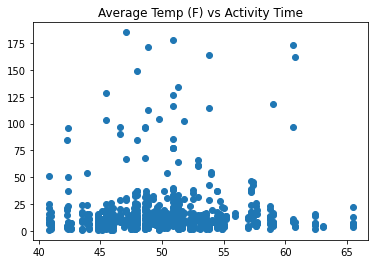

In [183]:
plt.figure()

#labels
plt.title("Average Temp (F) vs Activity Time")

#plot
plt.scatter(merged_df["Avg Temp"], study_abroad_df["Time Elapsed (min)"])
plt.show()

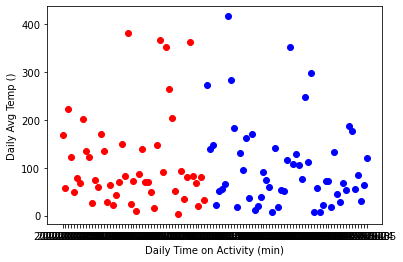

In [184]:
daily_total_time_first= first_half.groupby("Date")["Time Elapsed (min)"].sum()


daily_total_time_last= second_half.groupby("Date")["Time Elapsed (min)"].sum()


plt.figure()

#labels
plt.title("")
plt.xlabel("Daily Time on Activity (min)")
plt.ylabel("Daily Avg Temp ()")

#plot
plt.scatter(daily_total_time_first.index, daily_total_time_first, color="red")
plt.scatter(daily_total_time_last.index, daily_total_time_last, color="blue")
plt.show()

#### e. Number of Unique Activities per Day (Madrid)

In [185]:
grouped_by_date = study_abroad_df.groupby("Date")
unique_act_ser = grouped_by_date["Activity"].unique()

unique_act_amt_lst = []

for lst in unique_act_ser:
    unique_act_amt_lst.append(len(lst))

unique_act_amt_ser = pd.Series(unique_act_amt_lst, index=unique_act_ser.index)
unique_act_amt_ser

Date
2022-01-21    2
2022-01-22    1
2022-01-23    4
2022-01-24    1
2022-01-25    2
             ..
2022-05-01    1
2022-05-02    2
2022-05-03    1
2022-05-04    1
2022-05-05    2
Length: 104, dtype: int64

In [186]:
grouped_by_date = study_abroad_df.groupby("Date")
unique_act_amt_lst = []

for lst in unique_act_ser:
    unique_act_amt_lst.append(len(lst))

unique_act_amt_ser = pd.Series(unique_act_amt_lst, index=unique_act_ser.index)
unique_act_amt_ser

first_half = unique_act_amt_ser.iloc[0:52]
second_half = unique_act_amt_ser.iloc[52:104]
print(first_half.mean())
print(second_half.mean())

1.9423076923076923
1.75


#### f. Distance Weekend vs Weekday

In [187]:
weekend_lst = []
for i in range(study_abroad_df["Activity"].size):
    if(study_abroad_df["Day of Week"].iloc[i] == "Friday" or study_abroad_df["Day of Week"].iloc[i] == "Saturday" or study_abroad_df["Day of Week"].iloc[i] == "Sunday"):
        weekend_lst.append(True)
    else:
        weekend_lst.append(False)

study_abroad_df.insert(value=weekend_lst, column="Weekend", loc=2)

In [188]:
grouped_by_weekend = study_abroad_df.groupby("Weekend")

weekend_distance = grouped_by_weekend.get_group(True)["Distance (m)"]
weekday_distance = grouped_by_weekend.get_group(False)["Distance (m)"]

print(weekday_distance.mean())
print(weekend_distance.mean())

3134.3753424657534
16581.935018050543


### IV. Hypothesis Testing  
#### Test 1: Two Sample One Tailed Independent T Test of Mean Distance of Activity Segments Weekend vs Weekday (Madrid)  
* using my Google Maps dataset, I am going to see if the mean distance of my activity segments in Spain was greater than the mean distance of my activity segments in Spokane over the Summer.
* my significance level $\alpha$ will be 0.05.

Here are the formulas I will be using (independent, one tailed):
###### $$t = \frac{\overline{X}_{1} - \overline{X}_{2}}{\sqrt{S_{p}{2}(\frac{1}{n_{1}} + \frac{1}{n_{2}})}}$$

###### $$S_{p}^{2} = \frac{(n_{1} - 1)s_{1}^{2} + (n_{2} - 1)s_{2}^{2}}{n_{1} + n_{2} - 2}$$  
df = n1 + n2 - 2  
Lets find the degrees of freedom.

In [202]:
# n for both samples:
sa_n = weekday_distance.size
print(sa_n)

sum_n = weekday_distance.size
print(sum_n)
df = sa_n + sum_n - 2
print("Degrees of freedom is", df)

365
365
Degrees of freedom is 728


**Step 1: Identify $H_{0}$ and $H_1$**  
$H_{0}$ : $\mu_{Spain} \leq \mu_{Spokane}$   
$H_1$  : $\mu_{Spain} > \mu_{Spokane}$

**Step 2: Select Level of Significance**  
$\alpha$ = 0.05, meaning there is a 5% chance of making an error when rejecting the null hypothesis

In [190]:
alpha = 0.05

**Step 3: Select appropriate test statistic**  
for a one tailed, two sample independent t-test with $\alpha$ value 0.05 and df = 1003.
using a t-chart, t is about 1.6469.

In [191]:
t_crit = 1.6469

**Step 4: formulate the _decision rule_**

If $t_{computed} \leq$ 1.6469, do not reject $H_{0}$-->The population mean distance of activity segments in Spain is less than or equal to the population mean distance of activity segments in Spokane.   
If $t_{computed} >$ 1.6469, reject $H_{0}$-->The population mean distance of activity segments in Spain is greater than the population mean distance of activity segments in Spokane.

**Step 5: Make a Decision**  
* find $t_{computed}$

* apply decision rule

In [200]:
from scipy import stats

# get t and pvalue
t_comp, p_val = stats.ttest_ind(weekend_distance, weekday_distance)
p_val/=2
print("T is", f"{t_comp:.4f}", ", and p-value is", f"{p_val:.4f}")

# apply decision rule by testing pvalue
if(p_val < alpha):
     print("Reject H0. The population mean distance of activity segments in Spain is greater than the population mean distance of activity segments in Spokane")
else:
    print("Do not reject H0. The population mean distance of activity segments in Spain is less than or equal to the population mean distance of activity segments in Spokane.")

T is 3.5671 , and p-value is 0.0002
Reject H0. The population mean distance of activity segments in Spain is greater than the population mean distance of activity segments in Spokane


#### Test 2: Two Sample One-tailed Independent T Test of Daily Time Spent on Activities (Madrid vs Spokane)
* here I will be testing the mean travel activity between Spain and Spokane
* I will need to change the categorical travel activity data to numerical data using `sklearn.preprocessing.LabelEncoder()`.
* lets concatenate the two dataframes first for consistent encoding


Here are the formulas I will be using (independent, one tailed):
###### $$t = \frac{\overline{X}_{1} - \overline{X}_{2}}{\sqrt{S_{p}{2}(\frac{1}{n_{1}} + \frac{1}{n_{2}})}}$$

###### $$S_{p}^{2} = \frac{(n_{1} - 1)s_{1}^{2} + (n_{2} - 1)s_{2}^{2}}{n_{1} + n_{2} - 2}$$  
df = n1 + n2 - 2  
Lets find the degrees of freedom.

In [193]:

df = 1003
print("Degrees of freedom is", df)

Degrees of freedom is 1003


In Bus = 1, In Ferry = 2, In Passenger Vehicle = 3, In Subway = 4, In Train = 5, Unknown = 6, Walking = 7

**Step 1: Identify $H_{0}$ and $H_1$**  
$H_{0}$ : $\mu_{ActivitySpain} \leq \mu_{ActivitySpokane}$   
$H_1$  : $\mu_{ActivitySpain} > \mu_{ActivitySpokane}$

**Step 2: Select Level of Significance**  
$\alpha$ = 0.05, meaning there is a 5% chance of making an error when rejecting the null hypothesis

In [194]:
alpha = 0.05

**Step 3: Select appropriate test statistic**  
for a one tailed, two sample independent t-test with $\alpha$ value 0.05 and df = 1003.
using a t-chart, t is about 1.6469.

**Step 4: formulate the _decision rule_**

If $t_{computed} \leq$ 1.6469, do not reject $H_{0}$-->The population mean activity type in Spain is less than or equal to the population mean activity type in Spokane.  
If $t_{computed} >$ 1.6469, reject $H_{0}$-->The population mean activity type in Spain is greater than the population mean activity type in Spokane.

**Step 5: Make a Decision**  
* find $t_{computed}$

* apply decision rule

In [210]:
# get t and pvalue
t_comp, p_val = stats.ttest_ind(time_per_day_madrid, time_per_day_spokane)
p_val/=2
print("T is", f"{t_comp:.4f}", ", and p-value is", f"{p_val:.4f}")

# apply decision rule by testing pvalue
if(p_val < alpha):
     print("Reject H0. The population mean activity type in Spain is greater than the population mean activity type in Spokane.")
else:
    print("Do not reject H0. The population mean distance of activity segments in Spain is greater than or equal to the population mean distance of activity segments in Spokane.")

T is 1.7707 , and p-value is 0.0391
Reject H0. The population mean activity type in Spain is greater than the population mean activity type in Spokane.


## 3. Machine Learning  
In this section I will classify the data using the kNN algorithm and a Decision Tree Classiie.

In [196]:
X = study_abroad_df.drop("Weekend", axis=1)
y = study_abroad_df["Weekend"]

Take away uninformative cols

In [197]:
X.drop("Date", axis=1, inplace=True)
X.drop("Start Timestamp", axis=1, inplace=True)
X.drop("End Timestamp", axis=1, inplace=True)
X.drop("Day of Week", axis=1, inplace=True)
X.dropna(axis=1, inplace=True)
X

,Time Elapsed (min),Start Latitude,Start Longitude,End Latitude,End Longitude,Distance (m),Activity,Activity Code
0,7.374850,40.4072887,-3.7037391,40.4118401,-3.7052917,634,WALKING,7
1,24.522117,40.4124269,-3.7045765,40.4083941,-3.6930145,1289,WALKING,7
2,50.843183,40.4095404,-3.6928230,40.4181546,-3.7046289,2670,WALKING,7
3,11.013783,40.4167013,-3.7044784,40.4185364,-3.7098021,607,WALKING,7
4,8.123917,40.4163340,-3.7087356,40.4161470,-3.7032274,499,WALKING,7
...,...,...,...,...,...,...,...,...
637,2.057867,40.4182319,-3.7095123,40.4202932,-3.7059859,376,IN_SUBWAY,4
638,11.905133,40.4203902,-3.7063509,40.4069457,-3.7037075,2149,IN_SUBWAY,4
639,13.267133,40.4066533,-3.7035654,40.4047651,-3.7023939,610,WALKING,7
640,14.171500,40.4047651,-3.7023939,40.4262112,-3.7011621,2438,IN_SUBWAY,4


In [198]:
#divide into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, stratify=y)


In [199]:
# normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)
X_test_normalized = scaler.transform(X_test)


ValueError: could not convert string to float: 'WALKING'

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsClassifier(n_neighbors=3, metric="euclidean")

knn_clf.fit(X_train, y_train)
y_predicted = knn_clf.predict(X_test)
#print(y_predicted)
acc = accuracy_score(y_test, y_predicted)
print("accuracy :", acc)

accuracy : 0.5838509316770186


In [ ]:
from sklearn import tree

dt_clf = tree.DecisionTreeClassifier(max_depth=3, random_state=0)
dt_clf.fit(X_train, y_train) # "train"
y_predicted = dt_clf.predict(X_test)
acc = accuracy_score(y_test, y_predicted)
#print(y_predicted)
print("accuracy :", acc)

#plot tree
plt.figure(figsize=[20, 20])
tree.plot_tree(dt_clf, feature_names=X.columns, class_names={True:"Weekend", False:"Weekday"}, filled=True)

NameError: name 'X_train' is not defined

Future additons:
Test distance from home?
More daily aggregates
Look at pandemic data?  